In [ ]:
# !pip install numpy matplotlib scikit-learn pillow


In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.utils import shuffle
from sklearn.metrics import pairwise_distances_argmin
import random
from PIL import Image

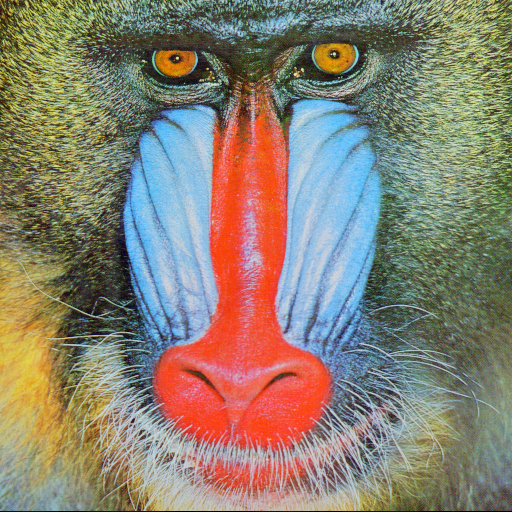

In [17]:
image_path = 'test.png'
image = Image.open(image_path)
image

In [18]:
image_np = np.array(image)
image_reshaped = image_np.reshape(-1, 3)
print(image_reshaped.shape)
image_np.shape


(262144, 3)


(512, 512, 3)

In [19]:
def init_centroids(num_clusters, data):

    m, _ = data.shape
    centroids_init = np.empty([num_clusters, 3])

    for i in range(num_clusters):
        rand_idx = random.randint(0, m - 1)
        centroids_init[i] = data[rand_idx]

    return centroids_init

In [20]:
def computeCentroid(features):

  return np.mean(features, axis=0)

In [21]:
def mykmeans(centroids, data, max_iter=5):

    m = data.shape[0]

    for i in range(max_iter):
        centroid_rgbs = {}

        for j in range(m):
            centroid = np.argmin(np.linalg.norm(centroids - data[j], axis=1))
            if centroid in centroid_rgbs:
                centroid_rgbs[centroid] = np.append(centroid_rgbs[centroid], [data[j]], axis=0)
            else:
                centroid_rgbs[centroid] = np.array([data[j]])

        for k in centroid_rgbs:
            centroids[k] = computeCentroid(centroid_rgbs[k])

    return centroids

In [22]:
def update_image(data, centroids):
    # Get the number of data points
    m = data.shape[0]

    # Create an empty array to store the new data
    new_data = np.empty_like(data)

    # Iterate over each data point
    for i in range(m):
        # Find the index of the nearest centroid for the current data point
        nearest_centroid = np.argmin(np.linalg.norm(centroids - data[i], axis=1))
        # Update the current data point with the coordinates of the nearest centroid
        new_data[i] = centroids[nearest_centroid]

    return new_data

In [23]:
def compress_image(image_data, centroids):
    labels = np.argmin(np.linalg.norm(centroids - image_data[:, np.newaxis], axis=2), axis=0)
    compressed_image = centroids[labels]
    compressed_image = compressed_image.reshape(image_data.shape)
    compressed_image = compressed_image.astype(np.uint8)
    return compressed_image

In [24]:
def display_images(original_img, compressed_img, title):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(original_img)
    ax[0].set_title('Original Image')
    ax[0].axis('off')
    ax[1].imshow(compressed_img)
    ax[1].set_title(title)
    ax[1].axis('off')
    plt.show()

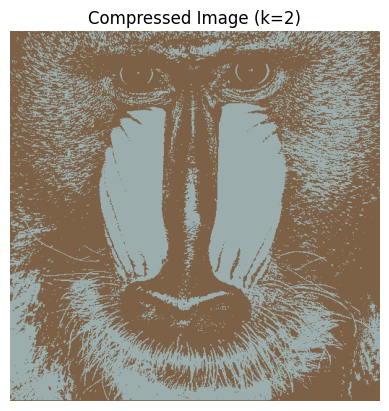

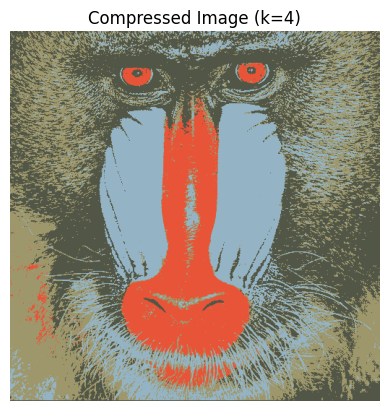

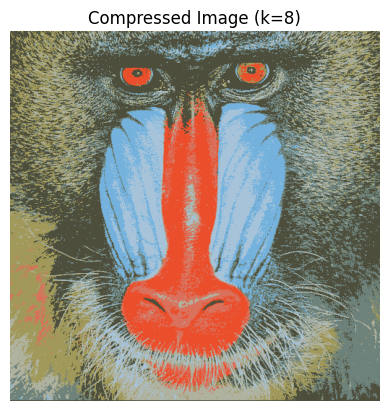

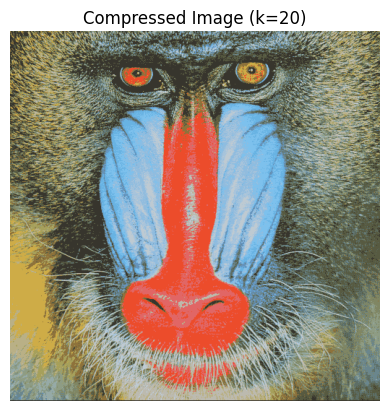

In [25]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np

# Define the number of clusters
num_clusters_list = [2, 4, 8, 20]

# Load the image and reshape it
image_path = 'test.png'
image = mpimg.imread(image_path)
image_reshaped = image.reshape(-1, 3)

# Iterate over different numbers of clusters
for num_clusters in num_clusters_list:
    # Initialize centroids
    initial_centroids = init_centroids(num_clusters, image_reshaped)

    # Perform K-means clustering
    final_centroids = mykmeans(initial_centroids, image_reshaped, max_iter=5)

    # Update image data with the final centroids
    image_compressed = update_image(image_reshaped, final_centroids)

    # Display the compressed image
    plt.imshow(image_compressed.reshape(image.shape))
    plt.axis('off')
    plt.title(f'Compressed Image (k={num_clusters})')
    plt.savefig(fname=f'monkey_compressed_{num_clusters}_clusters.png', format='png', dpi=300)
    plt.show()


In [26]:
image_path = 'test.png'
image = Image.open(image_path)
image_np = np.array(image)
image_reshaped = image_np.reshape(-1, 3)
print(image_reshaped.shape)
image_np.shape

(262144, 3)


(512, 512, 3)

In [27]:
kmeans = KMeans(n_clusters=6, random_state=0).fit(image_reshaped)
labels = kmeans.predict(image_reshaped)
centroids = kmeans.cluster_centers_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


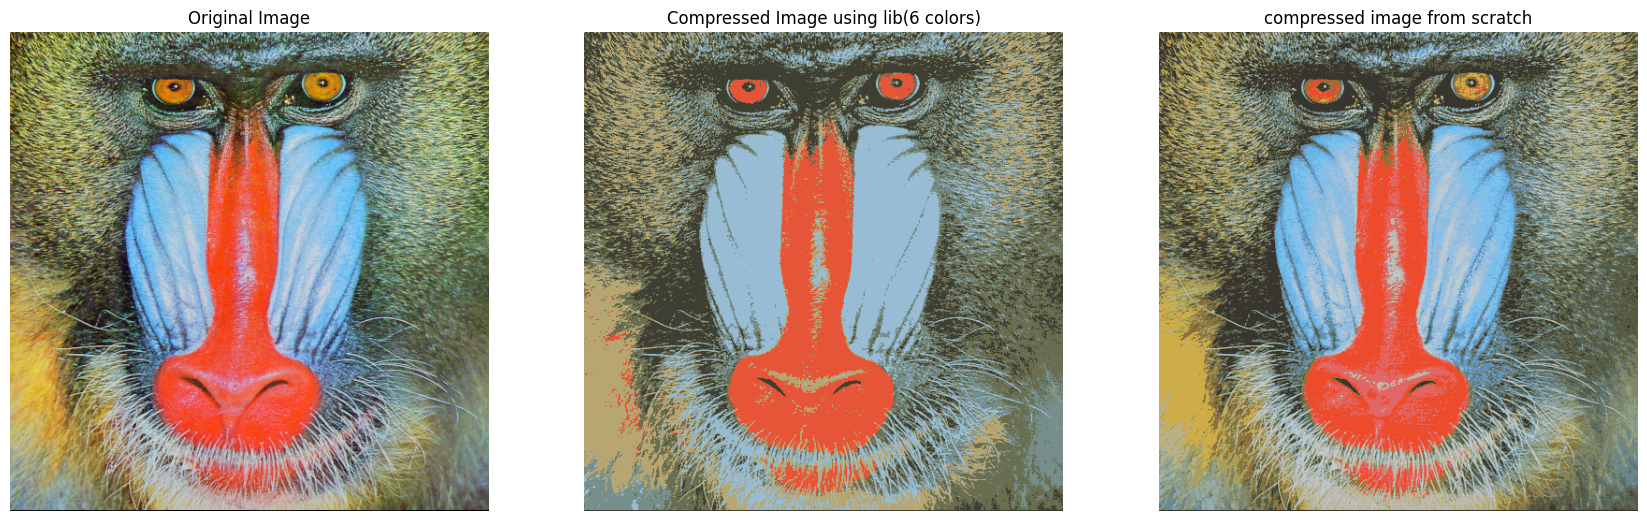

In [28]:
compressed_image = centroids[labels]
compressed_image = compressed_image.reshape(image_np.shape)
compressed_image = compressed_image.astype(np.uint8)
fig, ax = plt.subplots(1, 3, figsize=(21, 21))
ax[0].imshow(image)
ax[0].set_title('Original Image')
ax[0].axis('off')

ax[1].imshow(compressed_image)
ax[1].set_title('Compressed Image using lib({} colors)'.format(6))
ax[1].axis('off')

ax[2].imshow(image_compressed.reshape(image_np.shape))
ax[2].set_title('compressed image from scratch')
ax[2].axis('off')

plt.show()

In [29]:
def spatial_distance(pixel1, pixel2):
    # Calculate Euclidean distance between pixel coordinates
    return np.sqrt(np.sum((pixel1 - pixel2) ** 2))

def mykmeans_with_spatial_coherence(centroids, data, max_iter=5, spatial_weight=0.5):
    m = data.shape[0]

    for i in range(max_iter):
        centroid_rgbs = {}

        for j in range(m):
            # Calculate distances to centroids
            distances = np.linalg.norm(centroids - data[j], axis=1)
            # Calculate spatial distances to centroids
            spatial_distances = [spatial_distance(centroids[k], data[j]) for k in range(len(centroids))]
            # Combine color and spatial distances
            total_distances = distances + spatial_weight * np.array(spatial_distances)
            # Assign pixel to nearest centroid
            centroid = np.argmin(total_distances)
            if centroid in centroid_rgbs:
                centroid_rgbs[centroid] = np.append(centroid_rgbs[centroid], [data[j]], axis=0)
            else:
                centroid_rgbs[centroid] = np.array([data[j]])

        for k in centroid_rgbs:
            centroids[k] = computeCentroid(centroid_rgbs[k])

    return centroids

# Usage
initial_centroids = init_centroids(num_clusters, image_reshaped)
final_centroids_with_spatial = mykmeans_with_spatial_coherence(initial_centroids, image_reshaped, max_iter=5, spatial_weight=0.5)
image_compressed_with_spatial = update_image(image_reshaped, final_centroids_with_spatial)


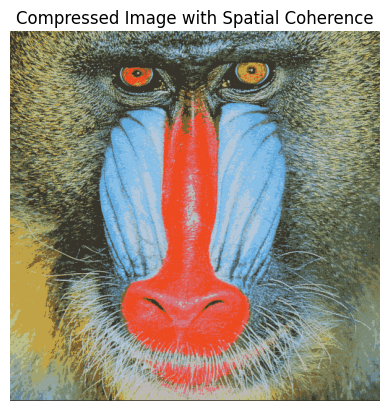

In [30]:
plt.imshow(image_compressed_with_spatial.reshape(image_np.shape))
plt.title('Compressed Image with Spatial Coherence')
plt.axis('off')
plt.show()

In [ ]:
#QUESTION-2

In [ ]:
# !pip install pandas scikit-learn matplotlib

In [31]:
from sklearn import datasets
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_moons

In [32]:
iris = datasets.load_iris(as_frame=True)
iris

{'data':      sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
 0                  5.1               3.5                1.4               0.2
 1                  4.9               3.0                1.4               0.2
 2                  4.7               3.2                1.3               0.2
 3                  4.6               3.1                1.5               0.2
 4                  5.0               3.6                1.4               0.2
 ..                 ...               ...                ...               ...
 145                6.7               3.0                5.2               2.3
 146                6.3               2.5                5.0               1.9
 147                6.5               3.0                5.2               2.0
 148                6.2               3.4                5.4               2.3
 149                5.9               3.0                5.1               1.8
 
 [150 rows x 4 columns],
 'target': 0     

In [33]:
data = pd.DataFrame(iris.data, columns=iris.feature_names)
target = pd.DataFrame(iris.target, columns=['target'])

# Combine into a single DataFrame
df = pd.concat([data, target], axis=1)

# Print the DataFrame
print(df.head())

   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

   target  
0       0  
1       0  
2       0  
3       0  
4       0  


In [34]:
df = df[df['target'].isin([0, 1])]

#
X = df[['petal length (cm)', 'petal width (cm)']]
y = df['target']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Print the first few rows of the DataFrame
print(pd.DataFrame(X_scaled, columns=['petal length (cm)', 'petal width (cm)']).head())

   petal length (cm)  petal width (cm)
0          -1.012978         -1.042111
1          -1.012978         -1.042111
2          -1.082312         -1.042111
3          -0.943643         -1.042111
4          -1.012978         -1.042111


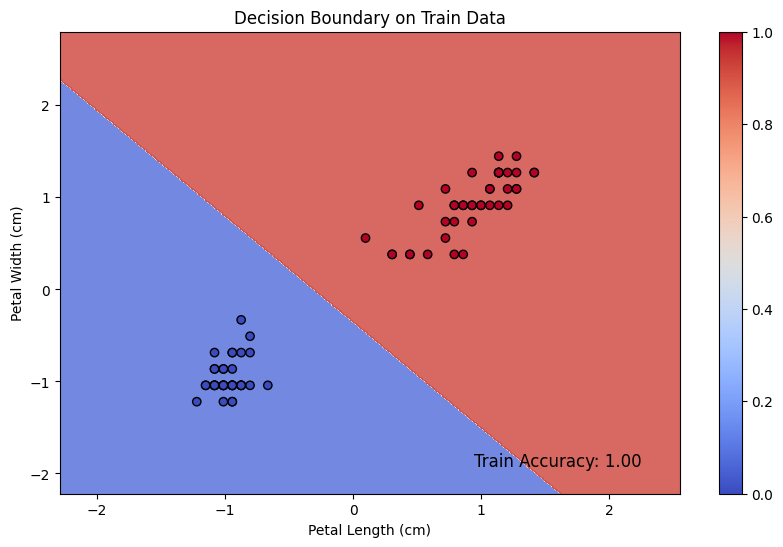

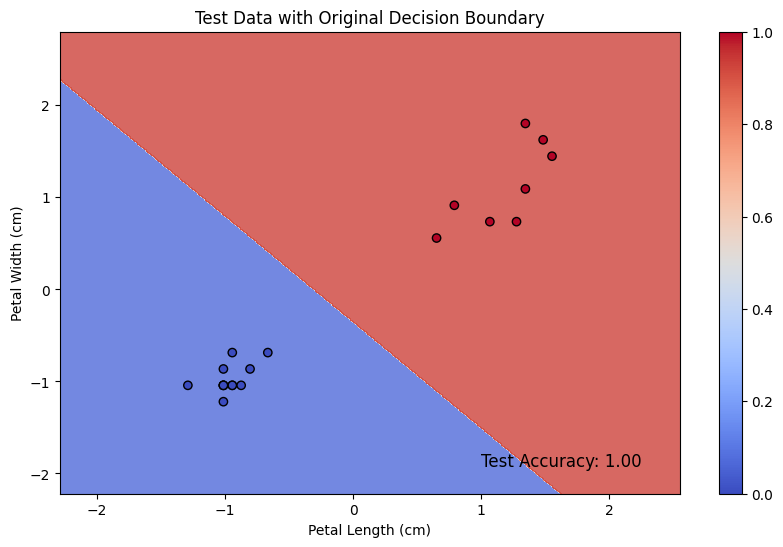

In [35]:
clf = LinearSVC(random_state=42)
clf.fit(X_train, y_train)

# Plot the decision boundary on the training data
plt.figure(figsize=(10, 6))

# Create a meshgrid of feature values
x_min, x_max = X_scaled[:, 0].min() - 1, X_scaled[:, 0].max() + 1
y_min, y_max = X_scaled[:, 1].min() - 1, X_scaled[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))

# Make predictions on the meshgrid points
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot decision boundary
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

# Plot train data
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.coolwarm, edgecolors='k')
plt.xlabel('Petal Length (cm)')
plt.ylabel('Petal Width (cm)')
plt.title('Decision Boundary on Train Data')
plt.colorbar()

# Calculate accuracy on the train data
train_accuracy = accuracy_score(y_train, clf.predict(X_train))
plt.text(xx.max() - 0.3, yy.min() + 0.3, ('Train Accuracy: %.2f' % train_accuracy).lstrip('0'),
         size=12, horizontalalignment='right')

plt.show()

# Generate scatterplot of the test data along with the original decision boundary
plt.figure(figsize=(10, 6))

# Plot decision boundary
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

# Plot test data
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=plt.cm.coolwarm, edgecolors='k')
plt.xlabel('Petal Length (cm)')
plt.ylabel('Petal Width (cm)')
plt.title('Test Data with Original Decision Boundary')
plt.colorbar()

# Calculate accuracy on the test data
test_accuracy = accuracy_score(y_test, clf.predict(X_test))
plt.text(xx.max() - 0.3, yy.min() + 0.3, ('Test Accuracy: %.2f' % test_accuracy).lstrip('0'),
         size=12, horizontalalignment='right')

plt.show()

In [36]:
X, y = make_moons(n_samples=500, noise=0.05, random_state=42)

# Print the shape of the dataset
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (500, 2)
Shape of y: (500,)


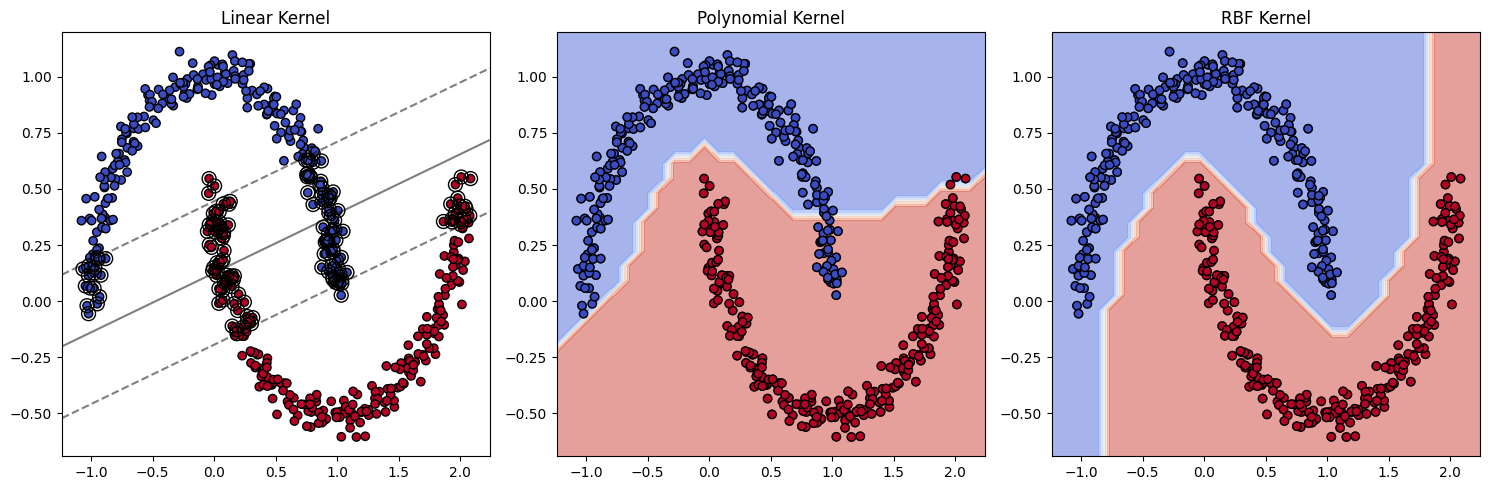

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC

# Train SVM models with different kernels
svm_linear = SVC(kernel='linear', random_state=42)
svm_poly = SVC(kernel='poly', degree=3, gamma='auto', random_state=42)  # Polynomial kernel with degree=3
svm_rbf = SVC(kernel='rbf', gamma='auto', random_state=42)  # RBF kernel

# Fit the models
svm_linear.fit(X, y)
svm_poly.fit(X, y)
svm_rbf.fit(X, y)

# Plot decision boundaries for each kernel
plt.figure(figsize=(15, 5))

# Linear kernel
plt.subplot(1, 3, 1)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', edgecolors='k')
plt.title("Linear Kernel")
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# Create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = svm_linear.decision_function(xy).reshape(XX.shape)

# Plot decision boundary and margins
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])
ax.scatter(svm_linear.support_vectors_[:, 0], svm_linear.support_vectors_[:, 1], s=100, linewidth=1, facecolors='none', edgecolors='k')

# Polynomial kernel
plt.subplot(1, 3, 2)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', edgecolors='k')
plt.title("Polynomial Kernel")
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# Create grid to evaluate model
Z = svm_poly.predict(np.c_[XX.ravel(), YY.ravel()]).reshape(XX.shape)

# Plot decision boundary
plt.contourf(XX, YY, Z, alpha=0.5, cmap='coolwarm')
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', edgecolors='k')

# RBF kernel
plt.subplot(1, 3, 3)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', edgecolors='k')
plt.title("RBF Kernel")
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# Create grid to evaluate model
Z = svm_rbf.predict(np.c_[XX.ravel(), YY.ravel()]).reshape(XX.shape)

# Plot decision boundary
plt.contourf(XX, YY, Z, alpha=0.5, cmap='coolwarm')
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', edgecolors='k')

plt.tight_layout()
plt.show()


In [38]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {'C': [0.1, 1, 10, 100],
              'gamma': [0.01, 0.1, 1, 10, 100]}

# Create the GridSearchCV object
grid_search = GridSearchCV(SVC(kernel='rbf', random_state=42), param_grid, cv=5, n_jobs=-1)

# Perform grid search
grid_search.fit(X, y)

# Print the best parameters found
print("Best parameters:", grid_search.best_params_)

# Get the best SVM model
best_svm_rbf = grid_search.best_estimator_


Best parameters: {'C': 0.1, 'gamma': 10}


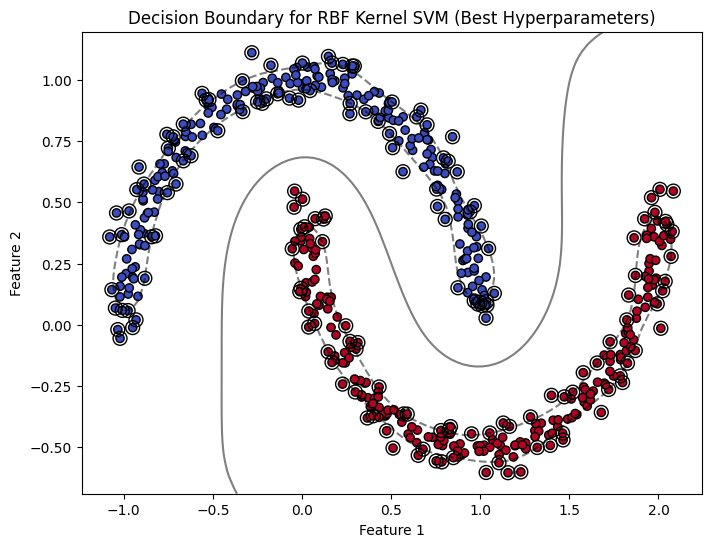

In [39]:
# Train RBF kernel SVM model with the best hyperparameters
best_gamma = grid_search.best_params_['gamma']
best_C = grid_search.best_params_['C']
best_svm_rbf = SVC(kernel='rbf', gamma=best_gamma, C=best_C, random_state=42)
best_svm_rbf.fit(X, y)

# Plot decision boundary for the RBF kernel SVM with best hyperparameters
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', edgecolors='k')

# Plot decision boundary
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# Create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 100)
yy = np.linspace(ylim[0], ylim[1], 100)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = best_svm_rbf.decision_function(xy).reshape(XX.shape)

ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])
ax.scatter(best_svm_rbf.support_vectors_[:, 0], best_svm_rbf.support_vectors_[:, 1], s=100, linewidth=1, facecolors='none', edgecolors='k')

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Decision Boundary for RBF Kernel SVM (Best Hyperparameters)')
plt.show()